In [1]:
## import torch
import tqdm
import numpy as np
import cv2
import imageio
import lpips
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import warp
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as ssim
from utils.common_utils import *
import warnings
from torchsummary import summary
from skimage import segmentation
from networks.conv_layers import *
from networks.skip import skip
from networks.unet import UNet
from networks.siren_module import Siren
from networks.p2s_module import _P2S
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from skimage.filters import gaussian

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

warnings.filterwarnings("ignore")

imsize = 256 #256 
total_num_inputs = 20

batch_size = 20

num_imgs_anytime = 1


pname = 'TCI_scene3'


/home/wj22/anaconda3/envs/implicit_turbu/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device: cuda
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
start_f = 1
fname = 'data/Ablation_data/{}/img'.format(pname)
fgt = 'data/Ablation_data/{}/GT/{}_GT.png'.format(pname,pname)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 1


fresult = 'result/{}'.format(pname)


if not os.path.exists(fresult):
    os.makedirs(fresult)

# Utility Functions

In [3]:
def backwarp(tenInput, tenFlow):
    backwarp_tenGrid = {}
    if str(tenFlow.size()) not in backwarp_tenGrid:
        tenHorizontal = torch.linspace(-1.0, 1.0, tenFlow.shape[3]).view(1, 1, 1, tenFlow.shape[3]).expand(tenFlow.shape[0], -1, tenFlow.shape[2], -1)
        tenVertical = torch.linspace(-1.0, 1.0, tenFlow.shape[2]).view(1, 1, tenFlow.shape[2], 1).expand(tenFlow.shape[0], -1, -1, tenFlow.shape[3])

        backwarp_tenGrid[str(tenFlow.size())] = torch.cat([ tenHorizontal, tenVertical ], 1).cuda()
    # end

    tenFlow = torch.cat([ tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0), tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0) ], 1)

    return torch.nn.functional.grid_sample(input=tenInput, grid=(backwarp_tenGrid[str(tenFlow.size())] + tenFlow).permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros')

def backwarp_grid(tenInput, tenFlow_xy):

    return torch.nn.functional.grid_sample(input=tenInput, grid = tenFlow_xy.permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros')

def im_resize(im, scale_factor):
    width = int(im.size[1] * scale_factor)
    height = int(im.size[0] * scale_factor)
    newsize = (height,width) 
#     im1 = im.resize(newsize) 
    return im.resize(newsize) 

def visualize_rgb(warp_np):
#     warp_np = warp_np.transpose(1,2,0)
    nr = warp_np.shape[0]
    nc = warp_np.shape[1]    
    warp_np = (warp_np - np.amin(warp_np))/(np.amax(warp_np) - np.amin(warp_np))
    one_pad = np.ones((nr, nc, 1))
    out_warp_np = np.concatenate((warp_np,one_pad),axis = -1)
    return out_warp_np

def visualize_rgb_norm(warp_np):
#     warp_np = warp_np.transpose(1,2,0)
    nr = warp_np.shape[0]
    nc = warp_np.shape[1]    
#     warp_np = (warp_np - np.amin(warp_np))/(np.amax(warp_np) - np.amin(warp_np))
    one_pad = np.ones((nr, nc, 1))
    out_warp_np = np.concatenate((warp_np,one_pad),axis = -1)
    return out_warp_np

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)

def fspecial_gaussian_2d(size, sigma):
    kernel = np.zeros(tuple(size))
    kernel[size[0]//2, size[1]//2] = 1
    kernel = gaussian(kernel, sigma)
    return kernel/np.sum(kernel)

class Gaussian_Blur(nn.Module):
    '''
    img (1, 3, H, W)
    # initialized as Gaussian_Blur
    '''
    def __init__(self, kernel_size=[7, 7], sigma=1.5):
        super().__init__()
        # size of the blur kernel
        self.kernel_size = kernel_size
        psf_2d = fspecial_gaussian_2d(kernel_size, sigma)
        psf_2d = torch.from_numpy(psf_2d)  # kernel_size, kernel_size
        gauss_psf = psf_2d[None, None, :] # 1, 1, kernel_size, kernel_size
        self.gauss_psf = nn.Parameter(gauss_psf.float())
        
    def forward(self, img):
        # img (1, 3, H, W)
        pad_size = self.kernel_size[0] // 2
        img_pad = F.pad(img.permute(1, 0, 2, 3), (pad_size,pad_size,pad_size,pad_size), mode = 'reflect')
        blur_img = F.conv2d(img_pad, self.gauss_psf).permute(1, 0, 2, 3) # (1, 3, H, W)
        return blur_img
    
class PSF_Blur(nn.Module):
    '''
    img (1, 3, H, W)
    # initialized as Gaussian_Blur
    '''
    def __init__(self, Dr0, img_size, device, corr, ker_size, data_path = './data/p2s_data'):
        super().__init__()
        self.ker_size = ker_size #33
        self.img_size = img_size
        self.initial_grid = 16 # 16
        self.Dr0 = torch.tensor(Dr0)
        self.device = device
        self.Dr0 = torch.tensor(Dr0).to(self.device,dtype=torch.float32)
        self.mapping = _P2S()
        self.mapping.load_state_dict(torch.load(os.path.join(data_path,'P2S_model.pt')))
        self.np_psf = np.load(os.path.join(data_path,'dictionary.npy'), allow_pickle = True)
        
        
        self.dict_psf = torch.tensor(self.np_psf.item()['dictionary'][:100,:]).reshape((100,1,33,33))
        self.dict_psf = F.interpolate(self.dict_psf, (self.ker_size,self.ker_size), 
                                      align_corners=False, mode='bilinear', antialias=True)
        self.dict_psf = self.dict_psf.to(self.device,dtype=torch.float32)
        norm_psf = torch.norm(self.dict_psf,dim=(2,3)).unsqueeze(-1).unsqueeze(-1)
        self.dict_psf = torch.div(self.dict_psf, norm_psf)
        new_var = torch.var(self.dict_psf[0,...])
        
        self.mu = torch.tensor(self.np_psf.item()['mu']).reshape((1,1,33,33)).to(self.device,dtype=torch.float32)
        self.mu = F.interpolate(self.mu, (self.ker_size,self.ker_size), 
                                      align_corners=False, mode='bilinear', antialias=False)
        old_var = torch.mean(self.mu)
        self.mu = self.mu * (new_var / old_var)
        
        self.R = np.load(os.path.join(data_path,'R-corr_{}_{}.npy'.format(corr, self.initial_grid)))
        self.R = torch.tensor(self.R).to(self.device, dtype=torch.float32)
        
        self.zer_coe = torch.sqrt(self.Dr0 ** (5 / 3))*torch.randn((self.initial_grid**2*36),1,device=self.device)
        self.zer_coe = nn.Parameter(self.zer_coe)
    
    def forward(self, img):
        pad_sz = self.ker_size//2
        img_pad = F.pad(img.view((-1,1,self.img_size,self.img_size)), 
                        (pad_sz,pad_sz,pad_sz,pad_sz), mode = 'reflect')
        img_mean = F.conv2d(img_pad, self.mu).squeeze()
        dict_img = F.conv2d(img_pad, self.dict_psf)
        

        zer = torch.matmul(self.R,self.zer_coe).view(self.initial_grid,self.initial_grid,36).permute(2,0,1).unsqueeze(0)
#         zer = self.zer_coe.view(self.initial_grid,self.initial_grid,36).permute(2,0,1).unsqueeze(0)

        zer = F.interpolate(zer,size=(self.img_size,self.img_size),mode='bilinear', align_corners=False)
        weight = self.mapping(zer.squeeze().permute(1,2,0).view(self.img_size**2,-1))
        
        weight = weight.view((self.img_size,self.img_size,100)).permute(2,0,1)# target: (100,512,512)
        out = torch.sum(weight.unsqueeze(0)*dict_img,1) + img_mean #  ( 3, H, W)
        out = out.unsqueeze(0) #  (1, 3, H, W)
        return out

def total_variation(img, reduction: str = "sum"):
    """Function that computes Total Variation according to [1].
    Args:
        img: the input image with shape :math:`(*, H, W)`.
        reduction : Specifies the reduction to apply to the output: ``'mean'`` | ``'sum'``.
         ``'mean'``: the sum of the output will be divided by the number of elements
         in the output, ``'sum'``: the output will be summed.
    Return:
         a tensor with shape :math:`(*,)`.
    Examples:
        >>> total_variation(torch.ones(4, 4))
        tensor(0.)
        >>> total_variation(torch.ones(2, 5, 3, 4, 4)).shape
        torch.Size([2, 5, 3])
    .. note::
       See a working example `here <https://kornia-tutorials.readthedocs.io/en/latest/
       total_variation_denoising.html>`__.
       Total Variation is formulated with summation, however this is not resolution invariant.
       Thus, `reduction='mean'` was added as an optional reduction method.
    Reference:
        [1] https://en.wikipedia.org/wiki/Total_variation
    """

    pixel_dif1 = img[..., 1:, :] - img[..., :-1, :]
    pixel_dif2 = img[..., :, 1:] - img[..., :, :-1]

    res1 = pixel_dif1.abs()
    res2 = pixel_dif2.abs()

    reduce_axes = (-2, -1)
    if reduction == "mean":
        if img.is_floating_point():
            res1 = res1.to(img).mean(dim=reduce_axes)
            res2 = res2.to(img).mean(dim=reduce_axes)
        else:
            res1 = res1.float().mean(dim=reduce_axes)
            res2 = res2.float().mean(dim=reduce_axes)
    elif reduction == "sum":
        res1 = res1.sum(dim=reduce_axes)
        res2 = res2.sum(dim=reduce_axes)

    return res1 + res2

def estimate_sharpness(img):
    # img B x C x H x W
    Gx, Gy = torch.gradient(img, dim=(2,3))
    S = torch.sqrt(Gx**2 + Gy**2)
    sharpness = torch.mean(S)
    return sharpness
 

# Load Turbulence Images 

0
data_0001.png
1
data_0002.png
2
data_0003.png
3
data_0004.png
4
data_0005.png
5
data_0006.png
6
data_0007.png
7
data_0008.png
8
data_0009.png
9
data_0010.png
10
data_0011.png
11
data_0012.png
12
data_0013.png
13
data_0014.png
14
data_0015.png
15
data_0016.png
16
data_0017.png
17
data_0018.png
18
data_0019.png
19
data_0020.png
(20, 3, 256, 256)


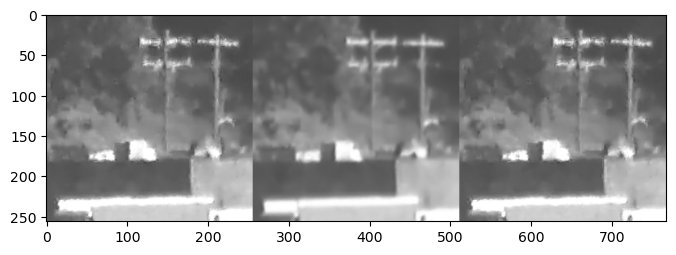

In [4]:
# Load reference GT pattern. If none, load a single turbulence image
img_gt_rgb,img_gt_np = get_image(fgt, imsize)
img_gt_np  = img_gt_np[:3,:,:]
dim_gt = img_gt_np.shape[0]
if dim_gt ==1:
    img_gt_np = np.concatenate((img_gt_np, img_gt_np,img_gt_np), 0)
    
images = []
images_anytime = []
i = 0

choosed_id = np.random.choice(total_num_inputs, batch_size, replace=False)
# # Load turbulence image batch

extensions = ['.jpg', '.JPG', '.png', '.ppm', '.bmp', '.pgm', '.tif']
# Load image by sorted name
for target in sorted(os.listdir(fname)):
    
    d = os.path.join(fname, target)
    if has_file_allowed_extension(d, extensions) and i in choosed_id:
#         print(d)
        print(i)
        print(target)

        rgb, imgs = get_image(d, imsize)
        imgs = pil_to_np(im_resize(rgb,scale_factor))
        dim = imgs.shape[0]
        if dim ==1:
            imgs = np.concatenate((imgs, imgs,imgs), 0)        
        images.append(imgs)
    if has_file_allowed_extension(d, extensions) and (i >= num_imgs_anytime and i < batch_size + num_imgs_anytime):     
        
        rgb, imgs = get_image(d, imsize)
        imgs = pil_to_np(im_resize(rgb,scale_factor))
        dim = imgs.shape[0]
        if dim ==1:
            imgs = np.concatenate((imgs, imgs,imgs), 0)        
        images_anytime.append(imgs)
    i = i+1
        
images_warp_np = np.array(images)
for _ in range(num_imgs_anytime):
    images_anytime.insert(0,images_anytime.pop())

images_anytime_np = np.array(images_anytime)

print(images_warp_np.shape)
images_mean_np = np.mean(images_warp_np, axis = 0)
# print(images_mean_np.shape)
dim, nr, nc = images_mean_np.shape


if dim>1:
    img_gt_np = cv2.resize(img_gt_np.transpose(1,2,0), dsize=(nc, nr), interpolation=cv2.INTER_AREA).transpose(2,0,1)
else:
    img_gt_np = cv2.resize(img_gt_np.transpose(1,2,0), dsize=(nc, nr), interpolation=cv2.INTER_AREA)

out_imshow = np.concatenate([images_warp_np[0].transpose(1,2,0),images_mean_np.transpose(1,2,0),img_gt_np.transpose(1,2,0)], axis = 1)
plt.figure(figsize=(8,5))
plt.imshow(out_imshow)
plt.show()

# Setup Fourier Feature Transform function

In [5]:
class GaussianFourierFeatureTransform_B(torch.nn.Module):
    """
    An implementation of Gaussian Fourier feature mapping.

    "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains":
       https://arxiv.org/abs/2006.10739
       https://people.eecs.berkeley.edu/~bmild/fourfeat/index.html

    Given an input of size [batches, num_input_channels, width, height],
     returns a tensor of size [batches, mapping_size*2, width, height].
    """

    def __init__(self, num_input_channels, B, mapping_size=256, scale=10):
        super().__init__()

        self._num_input_channels = num_input_channels
        self._mapping_size = mapping_size
        self._B = B*scale
#         self._B = torch.load('{}/{}_tensor_B.pt'.format(fresult,pname))

    def forward(self, x):
        assert x.dim() == 4, 'Expected 4D input (got {}D input)'.format(x.dim())

        batches, channels, width, height = x.shape

        assert channels == self._num_input_channels,\
            "Expected input to have {} channels (got {} channels)".format(self._num_input_channels, channels)

        # Make shape compatible for matmul with _B.
        # From [B, C, W, H] to [(B*W*H), C].
        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        x = x @ self._B.to(x.device)

        # From [(B*W*H), C] to [B, W, H, C]
        x = x.view(batches, width, height, self._mapping_size)
        # From [B, W, H, C] to [B, C, W, H]
        x = x.permute(0, 3, 1, 2)

        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

In [6]:
# Generate straight grid batch for shape image
xy_grid_batch = []
coords_x = np.linspace(-1, 1, nc)
coords_y = np.linspace(-1, 1, nr)
xy_grid = np.stack(np.meshgrid(coords_x, coords_y), -1)

xy_grid_var = np_to_torch(xy_grid.transpose(2,0,1)).type(dtype).cuda()
xy_grid_batch_var = xy_grid_var.repeat(batch_size, 1, 1, 1)
xy_grid_batch_var_anytime = xy_grid_var.repeat(batch_size, 1, 1, 1)

print(xy_grid_batch_var.shape)

torch.Size([20, 2, 256, 256])


In [7]:
print(xy_grid_var.shape)

torch.Size([1, 2, 256, 256])


# Setup Image Blur


In [8]:


model_imgblur = []
# for i in range(batch_size):
#     model_imgblur.append(Gaussian_Blur(kernel_size=[7, 7], sigma=1.5).to(device))

for i in range(batch_size):
    model_imgblur.append(PSF_Blur(Dr0=1.0, corr = -5, ker_size=33, img_size=nr, device=device).to(device))  
    # Dr0=0.1, corr=-5, ker_size=5 water turbulence
    # Dr0=1.0, corr = -5, ker_size=33 atmospheric turbulence

# for p in model_imgblur[0].parameters():
#     if p.requires_grad:
#         print(p.name, p.data) 
for i in range(batch_size):
    for name, param in model_imgblur[i].named_parameters():
        print(name)
        if param.requires_grad and 'mapping' in name:
            param.requires_grad = False



zer_coe
mapping.fc1.weight
mapping.fc1.bias
mapping.fc2.weight
mapping.fc2.bias
mapping.fc3.weight
mapping.fc3.bias
mapping.out.weight
mapping.out.bias
zer_coe
mapping.fc1.weight
mapping.fc1.bias
mapping.fc2.weight
mapping.fc2.bias
mapping.fc3.weight
mapping.fc3.bias
mapping.out.weight
mapping.out.bias
zer_coe
mapping.fc1.weight
mapping.fc1.bias
mapping.fc2.weight
mapping.fc2.bias
mapping.fc3.weight
mapping.fc3.bias
mapping.out.weight
mapping.out.bias
zer_coe
mapping.fc1.weight
mapping.fc1.bias
mapping.fc2.weight
mapping.fc2.bias
mapping.fc3.weight
mapping.fc3.bias
mapping.out.weight
mapping.out.bias
zer_coe
mapping.fc1.weight
mapping.fc1.bias
mapping.fc2.weight
mapping.fc2.bias
mapping.fc3.weight
mapping.fc3.bias
mapping.out.weight
mapping.out.bias
zer_coe
mapping.fc1.weight
mapping.fc1.bias
mapping.fc2.weight
mapping.fc2.bias
mapping.fc3.weight
mapping.fc3.bias
mapping.out.weight
mapping.out.bias
zer_coe
mapping.fc1.weight
mapping.fc1.bias
mapping.fc2.weight
mapping.fc2.bias
mapping.

# Setup Image Generator

In [9]:
# model_imgen = Siren(in_features=128, hidden_features=128, hidden_layers=5, out_features=3, outermost_linear=True,
#                     outermost_identity=False, first_omega_0 = 50., hidden_omega_0 = 30.)

# model_imgen = model_imgen.type(dtype)
# print(model_imgen)
# summary(model_imgen,(nr*nc, 128))

# # MLP
model_imgen = MLP(in_features=256, out_features=3, hidden_features=256)
model_imgen = model_imgen.type(dtype)
print(model_imgen)
summary(model_imgen,(nr*nc, 256))
                    

# model_imgen = conv_layers(256,3) #conv_layers
# model_imgen = model_imgen.type(dtype)
# # print(model_imgen)
# summary(model_imgen,(256, nr, nc))

torch.manual_seed(0)

# B_var = torch.randn(2,128)
B_var = torch.randn(2,128)
print(B_var.shape)


Sequential(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=3, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 65536, 256]          65,792
              ReLU-2           [-1, 65536, 256]               0
            Linear-3           [-1, 65536, 256]          65,792
              ReLU-4           [-1, 65536, 256]               0
            Linear-5           [-1, 65536, 256]          65,792
              ReLU-6           [-1, 65536, 256]               0
            Linear-7           [-1, 65536, 256]          65,792
              ReLU-8           [-1, 65536, 256]        

# Setup Grid deformer network 

In [10]:
# Use the skip net as grid deformor

input_depth_warp = 8
pad = 'reflection'

# -------------------------------------Use 10 grid-deform networks ---------------------------
# model_grid = []
# for i in range(batch_size):
#     model_grid.append(Siren(in_features=2, hidden_features=256, hidden_layers=5, out_features=2, 
#                             outermost_linear=True, outermost_identity=False, 
#                             first_omega_0 = 2., hidden_omega_0 = 30.).to(device))

# sum1 = summary(model_grid[0],(nr * nc, 2))

# model_grid = []
# for i in range(batch_size):
#     model_grid.append(MLP(in_features=2, out_features=2, hidden_features=256).to(device))

# sum1 = summary(model_grid[0],(nr * nc, 2))


model_grid = []
for i in range(batch_size):
    model_grid.append(conv_layers(2,2, need_sigmoid = False, need_tanh = True).to(device)) #conv_layers

sum1 = summary(model_grid[0],(2, nr, nc))

# -------------------------------------Use 1 grid-deform networks ---------------------------
# model_grid = conv_layers(2,2, need_sigmoid = False, need_tanh = True)

# model_grid = skip(2, 2,
#             num_channels_down = [128, 128, 128, 128, 128],   
#             num_channels_up   = [128, 128, 128, 128, 128],
#             num_channels_skip = [16, 16, 16, 16, 16],
#             upsample_mode='bilinear',
#             need_sigmoid=False, need_tanh=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

# model_grid = model_grid.type(dtype)
# # sum1 = summary(model_grid,(256, nr, nc))
# sum1 = summary(model_grid,(2, nr, nc))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 256, 256]             768
              ReLU-2        [-1, 256, 256, 256]               0
       BatchNorm2d-3        [-1, 256, 256, 256]             512
            Conv2d-4        [-1, 256, 256, 256]          65,792
              ReLU-5        [-1, 256, 256, 256]               0
            Conv2d-6        [-1, 256, 256, 256]          65,792
              ReLU-7        [-1, 256, 256, 256]               0
            Conv2d-8          [-1, 2, 256, 256]             514
              Tanh-9          [-1, 2, 256, 256]               0
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 898.00
Params size (MB): 0.51
Estimated Total Size (MB): 899.01
---------------------------------------

# Network Initializaiton

In [11]:
# The input turbulent images

# The frequence bandwith for the turbulence field
FB_img = 8 # 8

vec_scale = 1.1

reg_noise_std = 1./30. # set to 1./30 works fine

img_gt_batch_var = torch.from_numpy(images_warp_np).type(dtype).cuda()
img_gt_batch_var_anytime = torch.from_numpy(images_anytime_np).type(dtype).cuda()

straight_grid_input = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(xy_grid_batch_var)
straight_grid_input_anytime = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(xy_grid_batch_var_anytime)

# -------------------------------SETUP Grid deformer---------------------------------------------------
grid_input_single_gd = xy_grid_var.detach().clone()
grid_input_gd = xy_grid_batch_var.detach().clone()
# -------------------------------------------------------------------------------------------------------
grid_input = straight_grid_input.detach().clone()
grid_input_anytime = straight_grid_input_anytime.detach().clone()

# grid_input = xy_grid_batch_var.detach().clone()


In [12]:
print(xy_grid_batch_var.shape)
print(straight_grid_input.shape)

torch.Size([20, 2, 256, 256])
torch.Size([20, 256, 256, 256])


In [13]:
print(model_imgblur[0].parameters())

<generator object Module.parameters at 0x7f7d02a8c3c0>


In [14]:
model_params_list = [{'params':model_grid[i].parameters()} for i in range(batch_size)]

model_params_list.append({'params':model_imgen.parameters()})
for i in range(batch_size):
    non_frozen_parameters = [p for p in model_imgblur[i].parameters() if p.requires_grad]
    
model_params_list.append({'params': non_frozen_parameters})

print(model_params_list)

[{'params': <generator object Module.parameters at 0x7f7d02a8c4a0>}, {'params': <generator object Module.parameters at 0x7f7d02a8c510>}, {'params': <generator object Module.parameters at 0x7f7d02a8c580>}, {'params': <generator object Module.parameters at 0x7f7d02a8c5f0>}, {'params': <generator object Module.parameters at 0x7f7d02a8c660>}, {'params': <generator object Module.parameters at 0x7f7d02a8c6d0>}, {'params': <generator object Module.parameters at 0x7f7d02a8c740>}, {'params': <generator object Module.parameters at 0x7f7d02a8c7b0>}, {'params': <generator object Module.parameters at 0x7f7d02a8c820>}, {'params': <generator object Module.parameters at 0x7f7d02a8c890>}, {'params': <generator object Module.parameters at 0x7f7d02a8c900>}, {'params': <generator object Module.parameters at 0x7f7d02a8c970>}, {'params': <generator object Module.parameters at 0x7f7d02a8c9e0>}, {'params': <generator object Module.parameters at 0x7f7d02a8ca50>}, {'params': <generator object Module.parameters 

In [15]:
print(grid_input.shape)
print(nr)
print(img_gt_batch_var.shape)



torch.Size([20, 256, 256, 256])
256
torch.Size([20, 3, 256, 256])


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, loss = 1.027


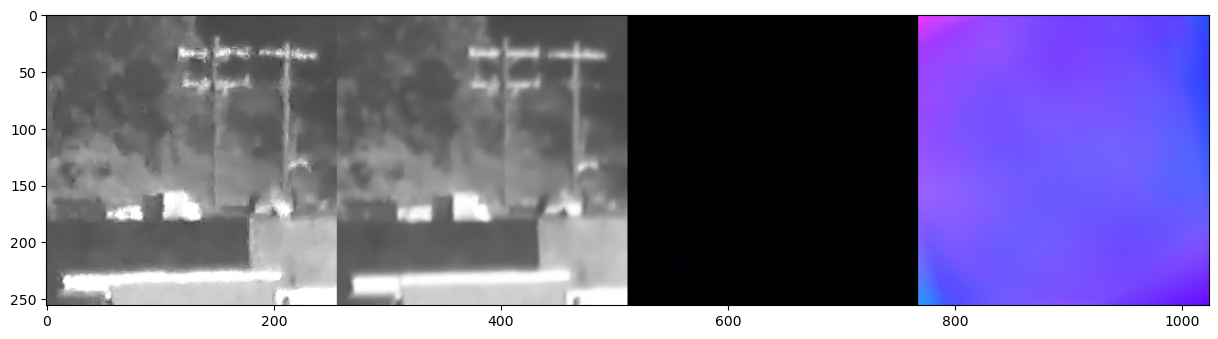

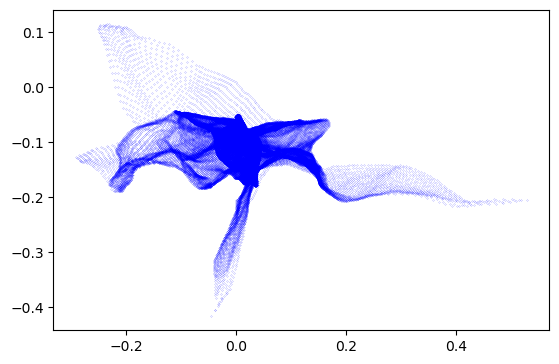

Epoch 100, loss = 0.136


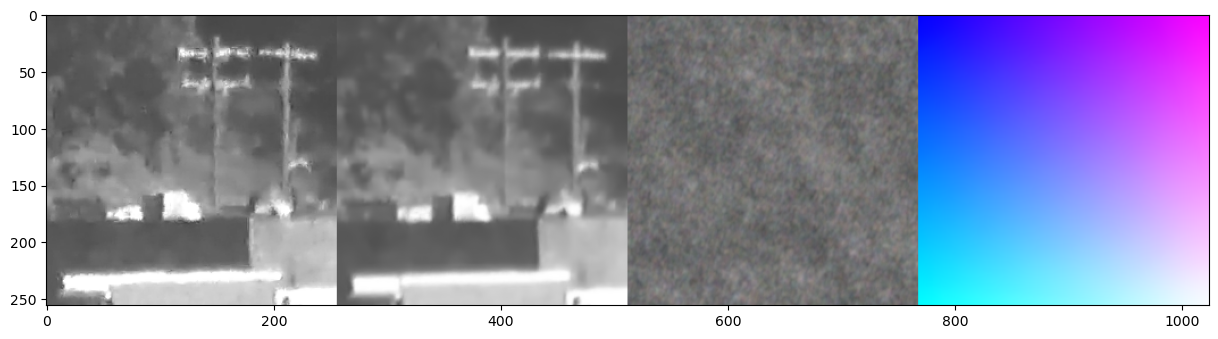

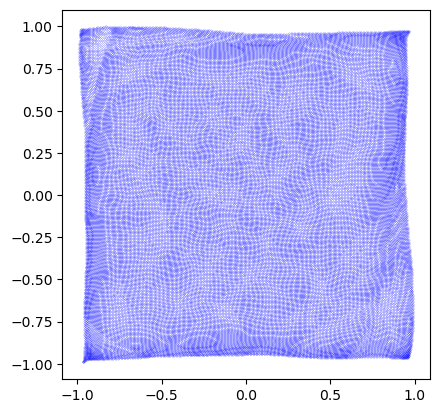

Epoch 200, loss = 0.106


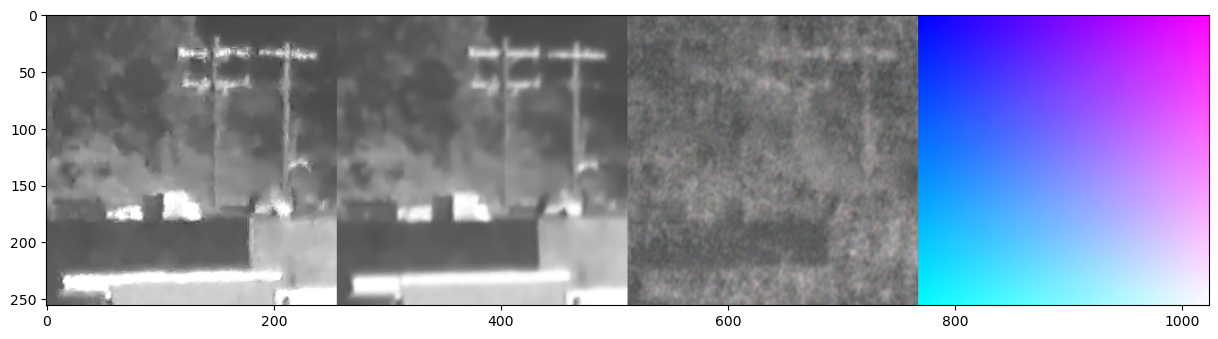

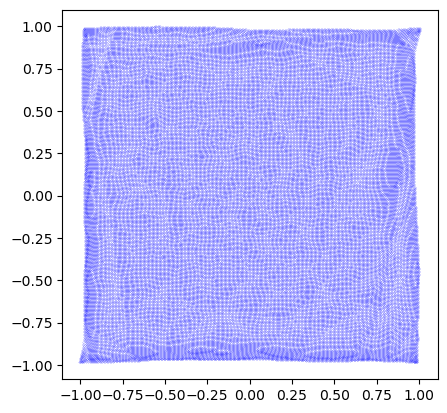

Epoch 300, loss = 0.036


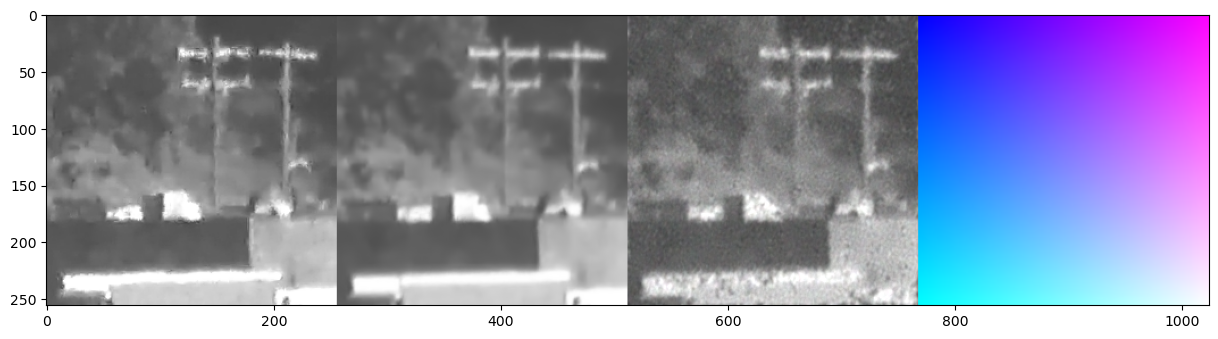

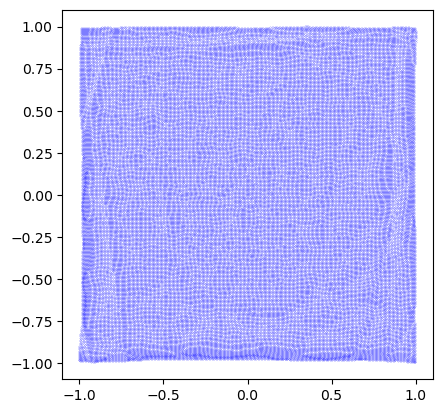

Epoch 400, loss = 0.024


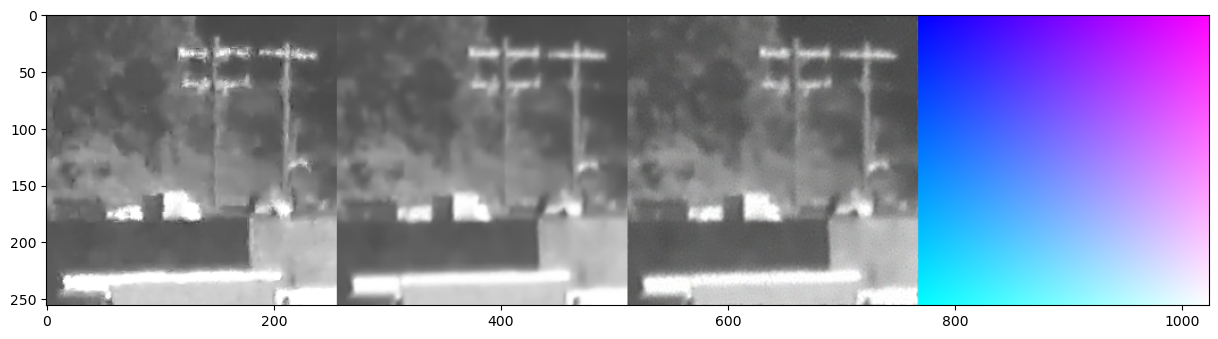

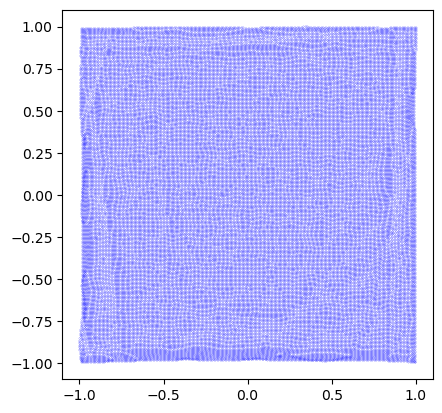

In [ ]:
optimizer = torch.optim.Adam(model_params_list, lr=1e-4)

num_iter_i = 1000

# imsave('{}/{}_turb_img_frame_{}.png'.format(fresult,pname,0), images_warp_np[0].transpose(1,2,0))
imsave('{}/{}_avg_img_{}.png'.format(fresult,pname,batch_size), images_mean_np.transpose(1,2,0))
for epoch in tqdm(range(num_iter_i)):    
    optimizer.zero_grad()
    
# -------------------------------SETUP Grid deformer---------------------------------------------------    
    refined_xy = []
    for b in range(batch_size):
        vec_input = grid_input_single_gd
        refined_xy.append(model_grid[b](vec_input))
#         refined_xy.append(model_grid[b](vec_input.permute(0, 2, 3, 1).reshape(-1, nr * nc, 2)).permute(0, 2, 1).reshape(-1, 2, nr, nc))
    refined_xy = vec_scale*torch.cat(refined_xy)
                
#     generated =  model_imgen(grid_input)#  grid_input
    generated =  model_imgen(grid_input.permute(0, 2, 3, 1).reshape(-1, nr * nc, 256)) # [10, nr * nc, 3]
    generated = generated.permute(0, 2, 1).reshape(-1, 3, nr, nc)

    loss = torch.nn.functional.l1_loss(img_gt_batch_var, generated)
    loss += torch.nn.functional.l1_loss(xy_grid_batch_var, refined_xy)    

    loss.backward()
    optimizer.step()   

    if epoch % 100 == 0:
        print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
        out_img = generated[0].detach().cpu().numpy().transpose(1,2,0)
        pred_xy = refined_xy[0].detach().cpu().numpy().transpose(1,2,0)
        out_imshow = np.concatenate([images_warp_np[0].transpose(1,2,0),images_mean_np.transpose(1,2,0),out_img,visualize_rgb(pred_xy)], axis = 1)
        plt.figure(figsize=(15,5))       
        plt.imshow(np.clip(out_imshow,0,1))
        plt.show()  
        pred_xy_lin = np.reshape(pred_xy, (-1, 2))
        
        plt.figure()
        plt.scatter(pred_xy_lin[:, 0], pred_xy_lin[:, 1], s=0.01, c='blue')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        
        plt.show()
imsave('{}/{}_ini_{}_{}.png'.format(fresult,pname,FB_img,batch_size), out_img)  

In [ ]:
# too much memory comment for now
# torch.save(model_imgen, '{}{}_ig_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))
# torch.save(model_grid, '{}{}_gd_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))
# torch.save(model_imgblur, '{}{}_ib_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))


# model_imgen = torch.load('{}/{}_ig_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f)).type(dtype).cuda()
# model_grid = torch.load('{}/{}_gd_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))

img_gt_np = img_gt_np.clip(0,1)

In [ ]:
print('{}{}_gd_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))
print('{}{}_ig_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))

# Training


In [ ]:
num_iter = 900
reg_noise_std = 1./30

# the reference frame in the plot
i = 0

loss_arr = torch.zeros(num_iter)
psnr_arr_sharp = torch.zeros(num_iter)
psnr_arr_turb = torch.zeros(num_iter)
ssim_arr_sharp = torch.zeros(num_iter)
ssim_arr_turb = torch.zeros(num_iter)
# seed = torch.seed()

optimizer = torch.optim.Adam(model_params_list, lr=1e-4)

for epoch in tqdm(range(num_iter)):
      
    optimizer.zero_grad()   
    
# -------------------------------SETUP Grid deformer---------------------------------------------------
    refined_xy = []
    for b in range(batch_size):
        vec_input = grid_input_single_gd 
        refined_xy.append(model_grid[b](vec_input))
#         refined_xy.append(model_grid[b](vec_input.permute(0, 2, 3, 1).reshape(-1, nr * nc, 2)).permute(0, 2, 1).reshape(-1, 2, nr, nc))
    
    refined_xy = vec_scale*torch.cat(refined_xy)
    refined_warp = refined_xy - xy_grid_batch_var
    refined_uv = torch.cat(((nc - 1.0)*refined_warp[:, 0:1, :, :]/2 , (nr - 1.0)*refined_warp[:, 1:2, :, :]/2), 1)
    
    # Get mask for the warp field
    mask_u1 = (refined_xy[:,0:1,:,:] > -1).float() * 1
    mask_u2 = (refined_xy[:,0:1,:,:] < 1).float() * 1 
    mask_v1 = (refined_xy[:,1:2,:,:] > -1).float() * 1
    mask_v2 = (refined_xy[:,1:2,:,:] < 1).float() * 1  
    mask = mask_u1*mask_u2*mask_v1*mask_v2
    
    # predict sharp image using straight grid
#     sharp_imgs_predict = model_imgen(grid_input) #grid_input
    sharp_imgs_predict = model_imgen(grid_input.permute(0, 2, 3, 1).reshape(-1, nr * nc, 256))
    sharp_imgs_predict = sharp_imgs_predict.permute(0, 2, 1).reshape(-1, 3, nr, nc)
    
    # predict turbulent images using sampling grid 
    refined_turb_imgs = backwarp_grid(sharp_imgs_predict,refined_xy) # [B, 3, H, W]
    
    # ***predict turbulent images using sampling grid  (blur)
    refined_turb_imgs_list = []
    for b in range(batch_size):
        refined_turb_imgs_list.append(model_imgblur[b](refined_turb_imgs[b:b+1, :]))
    refined_turb_imgs = torch.cat(refined_turb_imgs_list)
    
    # predict turbulent image using forward mapping
#     generated_turb_imgs = model_imgen(GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy))
    pe_xy = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy).permute(0, 2, 3, 1).reshape(-1, nr * nc, 256)
    # [10, nr * nc, 256]
    generated_turb_imgs = model_imgen(pe_xy) # [10, nr * nc, 3]
    
    generated_turb_imgs = generated_turb_imgs.permute(0, 2, 1).reshape(-1, 3, nr, nc)
    # blur
    generated_turb_imgs_list = []
    for b in range(batch_size):
        generated_turb_imgs_list.append(model_imgblur[b](generated_turb_imgs[b:b+1, :]))
    generated_turb_imgs = torch.cat(generated_turb_imgs_list)
    
#     generated_turb_imgs = model_imgen(refined_xy)
    
    # loss function
    loss = torch.nn.functional.l1_loss(generated_turb_imgs*mask,img_gt_batch_var*mask) # loss 1
    loss += torch.nn.functional.l1_loss(refined_turb_imgs*mask,img_gt_batch_var*mask)   # loss 2
    loss += torch.nn.functional.l1_loss(generated_turb_imgs*mask,refined_turb_imgs*mask) # loss 3
    # tv 
    lamb_tv = 0.0 #0.2
    loss_tv = total_variation(
                            sharp_imgs_predict, 
                            reduction='mean'
                            ).mean()
    loss += lamb_tv * loss_tv
    # sharpness
    lamb_sharp = 0.0 #0.2
    loss_sharp = estimate_sharpness(sharp_imgs_predict)
    loss += lamb_sharp * (2.0 - loss_sharp)
    
#     loss += torch.nn.functional.l1_loss(img_gt_batch_var*mask, sharp_imgs_predict*mask)
#     loss += torch.nn.functional.l1_loss(xy_grid_batch_var, refined_xy)    
    
    loss_arr[epoch] = loss
#     psnr_arr_sharp[epoch] = compare_psnr(img_gt_np, sharp_imgs_predict[i].detach().cpu().numpy(), data_range=1) 
#     psnr_arr_turb[epoch]   = compare_psnr(images_warp_np[i], generated_turb_imgs[i].detach().cpu().numpy(), data_range=1) 
    psnr_arr_sharp[epoch] = compare_psnr(img_gt_np, sharp_imgs_predict[i].detach().cpu().numpy()) 
    psnr_arr_turb[epoch]   = compare_psnr(images_warp_np[i], generated_turb_imgs[i].detach().cpu().numpy()) 
    
#     ssim_arr_sharp[epoch] = ssim(img_gt_np.transpose(1,2,0).astype(float), sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True, data_range=1) 
#     ssim_arr_turb[epoch]   = ssim(images_warp_np[i].transpose(1,2,0).astype(float), generated_turb_imgs[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True, data_range=1) 
    ssim_arr_sharp[epoch] = ssim(img_gt_np.transpose(1,2,0).astype(float), sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True) 
    ssim_arr_turb[epoch]   = ssim(images_warp_np[i].transpose(1,2,0).astype(float), generated_turb_imgs[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True)  

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0 or epoch == 0:
        print('Epoch %d, loss = %.03f, psnr_sharp = %.03f, psnr_turb = %.03f, ssim_sharp = %.03f, ssim_turb = %.03f' % (epoch, float(loss), float(psnr_arr_sharp[epoch]), float(psnr_arr_turb[epoch]), float(ssim_arr_sharp[epoch]), float(ssim_arr_turb[epoch])))
        
        out_img = refined_turb_imgs[i]*mask[i]
        out_img = out_img.detach().cpu().numpy().transpose(1,2,0)
        sharp_img = sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0)
        warp_img= refined_uv[i].detach().cpu().numpy().transpose(1,2,0)
        out_target = images_warp_np[i].transpose(1,2,0)

        out_imshow = np.concatenate([out_target,out_img,visualize_rgb(warp_img),sharp_img], axis = 1)
        plt.figure(figsize=(20,5))       
        plt.imshow(np.clip(out_imshow,0,1))
        plt.show()
        
        pred_xy = refined_xy[0].detach().cpu().numpy().transpose(1,2,0)
        pred_xy_lin = np.reshape(pred_xy, (-1, 2))
        plt.figure()
        plt.scatter(pred_xy_lin[:, 0], pred_xy_lin[:, 1], s=0.01, c='blue')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        plt.show()

# Anytime


In [ ]:
# print(fresult)
# gd_init_stat_dict = torch.load('{}{}_gd_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))

# ib_init_stat_dict = torch.load('{}{}_ib_scale_{}_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,start_f))


In [ ]:
# model_grid[0].load_state_dict(gd_init_stat_dict[0].state_dict())
# model_imgblur[0].load_state_dict(ib_init_stat_dict[0].state_dict())

In [ ]:
# num_iter = 1000
# reg_noise_std = 1./30

# # the reference frame in the plot
# i = 0

# loss_arr_anytime = torch.zeros(num_iter)
# psnr_arr_sharp = torch.zeros(num_iter)
# psnr_arr_turb = torch.zeros(num_iter)
# ssim_arr_sharp = torch.zeros(num_iter)
# ssim_arr_turb = torch.zeros(num_iter)
# # seed = torch.seed()

# optimizer = torch.optim.Adam(model_params_list, lr=1e-4)

# for epoch in tqdm(range(num_iter)):
      
#     optimizer.zero_grad()   
    
# # -------------------------------SETUP Grid deformer---------------------------------------------------
#     refined_xy = []
#     for b in range(batch_size):
#         vec_input = grid_input_single_gd 
#         refined_xy.append(model_grid[b](vec_input))
# #         refined_xy.append(model_grid[b](vec_input.permute(0, 2, 3, 1).reshape(-1, nr * nc, 2)).permute(0, 2, 1).reshape(-1, 2, nr, nc))
    
#     refined_xy = vec_scale*torch.cat(refined_xy)
#     refined_warp = refined_xy - xy_grid_batch_var_anytime
#     refined_uv = torch.cat(((nc - 1.0)*refined_warp[:, 0:1, :, :]/2 , (nr - 1.0)*refined_warp[:, 1:2, :, :]/2), 1)
    
#     # Get mask for the warp field
#     mask_u1 = (refined_xy[:,0:1,:,:] > -1).float() * 1
#     mask_u2 = (refined_xy[:,0:1,:,:] < 1).float() * 1 
#     mask_v1 = (refined_xy[:,1:2,:,:] > -1).float() * 1
#     mask_v2 = (refined_xy[:,1:2,:,:] < 1).float() * 1  
#     mask = mask_u1*mask_u2*mask_v1*mask_v2
    
#     # predict sharp image using straight grid
# #     sharp_imgs_predict = model_imgen(grid_input) #grid_input
#     sharp_imgs_predict = model_imgen(grid_input_anytime.permute(0, 2, 3, 1).reshape(-1, nr * nc, 256))
#     sharp_imgs_predict = sharp_imgs_predict.permute(0, 2, 1).reshape(-1, 3, nr, nc)
    
#     # predict turbulent images using sampling grid 
#     refined_turb_imgs = backwarp_grid(sharp_imgs_predict,refined_xy) # [B, 3, H, W]
    
#     # ***predict turbulent images using sampling grid  (blur)
#     refined_turb_imgs_list = []
#     for b in range(batch_size):
#         refined_turb_imgs_list.append(model_imgblur[b](refined_turb_imgs[b:b+1, :]))
#     refined_turb_imgs = torch.cat(refined_turb_imgs_list)
    
#     # predict turbulent image using forward mapping
# #     generated_turb_imgs = model_imgen(GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy))
#     pe_xy = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy).permute(0, 2, 3, 1).reshape(-1, nr * nc, 256)
#     # [10, nr * nc, 256]
#     generated_turb_imgs = model_imgen(pe_xy) # [10, nr * nc, 3]
    
#     generated_turb_imgs = generated_turb_imgs.permute(0, 2, 1).reshape(-1, 3, nr, nc)
#     # blur
#     generated_turb_imgs_list = []
#     for b in range(batch_size):
#         generated_turb_imgs_list.append(model_imgblur[b](generated_turb_imgs[b:b+1, :]))
#     generated_turb_imgs = torch.cat(generated_turb_imgs_list)
# #     generated_turb_imgs = model_imgen(refined_xy)
#     # loss function
#     loss = torch.nn.functional.l1_loss(generated_turb_imgs*mask,img_gt_batch_var_anytime*mask) 
#     loss += torch.nn.functional.l1_loss(refined_turb_imgs*mask,img_gt_batch_var_anytime*mask)  
#     loss += torch.nn.functional.l1_loss(generated_turb_imgs*mask,refined_turb_imgs*mask)
#     # tv 
#     lamb_tv = 0.0 #0.2
#     loss_tv = total_variation(
#                             sharp_imgs_predict, 
#                             reduction='mean'
#                             ).mean()
#     loss += lamb_tv * loss_tv
#     # sharpness
#     lamb_sharp = 0.0 #0.2
#     loss_sharp = estimate_sharpness(sharp_imgs_predict)
#     loss += lamb_sharp * (2.0 - loss_sharp)
    
# #     loss += torch.nn.functional.l1_loss(img_gt_batch_var*mask, sharp_imgs_predict*mask)
# #     loss += torch.nn.functional.l1_loss(xy_grid_batch_var, refined_xy)    
    
#     loss_arr_anytime[epoch] = loss
# #     psnr_arr_sharp[epoch] = compare_psnr(img_gt_np, sharp_imgs_predict[i].detach().cpu().numpy(), data_range=1) 
# #     psnr_arr_turb[epoch]   = compare_psnr(images_warp_np[i], generated_turb_imgs[i].detach().cpu().numpy(), data_range=1) 
#     psnr_arr_sharp[epoch] = compare_psnr(img_gt_np, sharp_imgs_predict[i].detach().cpu().numpy()) 
#     psnr_arr_turb[epoch]   = compare_psnr(images_warp_np[i], generated_turb_imgs[i].detach().cpu().numpy()) 
    
# #     ssim_arr_sharp[epoch] = ssim(img_gt_np.transpose(1,2,0).astype(float), sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True, data_range=1) 
# #     ssim_arr_turb[epoch]   = ssim(images_warp_np[i].transpose(1,2,0).astype(float), generated_turb_imgs[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True, data_range=1) 
#     ssim_arr_sharp[epoch] = ssim(img_gt_np.transpose(1,2,0).astype(float), sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True) 
#     ssim_arr_turb[epoch]   = ssim(images_anytime_np[i].transpose(1,2,0).astype(float), generated_turb_imgs[i].detach().cpu().numpy().transpose(1,2,0).astype(float),multichannel=True)  

#     loss.backward()
#     optimizer.step()

#     if epoch % 100 == 0:
#         print('Epoch %d, loss = %.03f, psnr_sharp = %.03f, psnr_turb = %.03f, ssim_sharp = %.03f, ssim_turb = %.03f' % (epoch, float(loss), float(psnr_arr_sharp[epoch]), float(psnr_arr_turb[epoch]), float(ssim_arr_sharp[epoch]), float(ssim_arr_turb[epoch])))
        
#         out_img = refined_turb_imgs[i]*mask[i]
#         out_img = out_img.detach().cpu().numpy().transpose(1,2,0)
#         sharp_img = sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0)
#         warp_img= refined_uv[i].detach().cpu().numpy().transpose(1,2,0)
#         out_target = images_anytime_np[i].transpose(1,2,0)

#         out_imshow = np.concatenate([out_target,out_img,visualize_rgb(warp_img),sharp_img], axis = 1)
#         plt.figure(figsize=(20,5))       
#         plt.imshow(np.clip(out_imshow,0,1))
#         plt.show()
        
#         pred_xy = refined_xy[0].detach().cpu().numpy().transpose(1,2,0)
#         pred_xy_lin = np.reshape(pred_xy, (-1, 2))
#         plt.figure()
#         plt.scatter(pred_xy_lin[:, 0], pred_xy_lin[:, 1], s=0.01, c='blue')
#         ax = plt.gca()
#         ax.set_aspect('equal', adjustable='box')
#         plt.show()

In [ ]:
# print((generated_turb_imgs*mask).shape)
# print((img_gt_batch_var_anytime.shape))
# print('{}/{}_loss_anytime_{}_{}.pt'.format(fresult,pname,FB_img,batch_size))

In [ ]:
# print(float(loss))
# loss_arr_anytime_np = loss_arr_anytime.detach().cpu().numpy()
# plt.plot(loss_arr_anytime_np[:400])
# plt.plot(loss_arr.detach().numpy()[:400])
# plt.ylabel('Training loss')
# plt.xlabel('Number of epochs')
# plt.legend(['Anytime reconstruction', 'Two-step optimization (initialization)'])
# plt.show()
# torch.save(loss_arr_anytime_np, '{}/{}_loss_anytime_{}_{}.pt'.format(fresult,pname,FB_img,batch_size))
# torch.save(loss_arr, '{}/{}_loss_final_{}_{}.pt'.format(fresult,pname,FB_img,batch_size))


In [ ]:
# torch.save(model_grid, '{}/{}_gd_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
# torch.save(model_imgen, '{}/{}_ig_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
# torch.save(loss_arr, '{}/{}_loss_final_{}_{}.pt'.format(fresult,pname,FB_img,batch_size))
# torch.save(psnr_arr_sharp, '{}/{}_psnr_sharp_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
# torch.save(psnr_arr_turb, '{}/{}_psnr_turb_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
# torch.save(ssim_arr_sharp, '{}/{}_ssim_sharp_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
# torch.save(ssim_arr_turb, '{}/{}_ssim_turb_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))

# Test

In [ ]:
# model_grid = torch.load('{}/{}_gd_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
# model_imgen = torch.load('{}/{}_ig_final_{}_{}.pth'.format(fresult,pname,FB_img,batch_size)).type(dtype).cuda()

fresult = '{}/{}/'.format(fresult,batch_size)
if not os.path.exists(fresult):
    os.makedirs(fresult)
    
# -------------------------------SETUP Grid deformer---------------------------------------------------    
refined_xy = []
for b in range(batch_size):
    refined_xy.append(model_grid[b](grid_input_single_gd))
#     refined_xy.append(model_grid[b](grid_input_single_gd.permute(0, 2, 3, 1).reshape(-1, nr * nc, 2)).permute(0, 2, 1).reshape(-1, 2, nr, nc))
    
    

refined_xy = vec_scale*torch.cat(refined_xy)
refined_warp = refined_xy - xy_grid_batch_var
refined_uv = torch.cat([(nc - 1.0)*refined_warp[:, 0:1, :, :]/2 , (nr - 1.0)*refined_warp[:, 1:2, :, :]/2], 1)

# refined_uv -= refined_uv.min()
# refined_uv /= refined_uv.max()

# generated_turb_imgs = model_imgen(GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy))
pe_xy = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy).permute(0, 2, 3, 1).reshape(-1, nr * nc, 256)
# # [10, nr * nc, 256]
generated_turb_imgs = model_imgen(pe_xy) # [10, nr * nc, 3]
generated_turb_imgs = generated_turb_imgs.permute(0, 2, 1).reshape(-1, 3, nr, nc)

# blur
generated_turb_imgs_list = []
for b in range(batch_size):
    generated_turb_imgs_list.append(model_imgblur[b](generated_turb_imgs[b:b+1, :]))
generated_turb_imgs = torch.cat(generated_turb_imgs_list)


# sharp_imgs_predict = model_imgen(grid_input)
sharp_imgs_predict = model_imgen(grid_input.permute(0, 2, 3, 1).reshape(-1, nr * nc, 256))
sharp_imgs_predict = sharp_imgs_predict.permute(0, 2, 1).reshape(-1, 3, nr, nc)

    
# gamma correct
gamma = 1.0 # 2.2
sharp_imgs_predict_gamma = sharp_imgs_predict ** gamma

psnr_arr= compare_psnr(img_gt_np, sharp_imgs_predict[0].detach().cpu().numpy()) 
ssim_arr = ssim(img_gt_np.transpose(1,2,0), sharp_imgs_predict[0].detach().cpu().numpy().transpose(1,2,0),multichannel=True) 
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex', normalize=True).to(device)
lpips_img1 = torch.from_numpy(img_gt_np).unsqueeze(0)
lpips_img1 = lpips_img1.to(device)
lpips_img2 = torch.clamp(sharp_imgs_predict[0].unsqueeze(0), 0.0, 1.0)
lpips_img2 = lpips_img2.to(device)
lpips_arr = lpips(lpips_img1, lpips_img2)
print('PSNR: {}, SSIM: {}, LPIPS: {}'.format(psnr_arr,ssim_arr,lpips_arr))
for j in range(batch_size):

    out_img = generated_turb_imgs[j].detach().cpu().numpy().transpose(1,2,0)
    sharp_img = sharp_imgs_predict[j].detach().cpu().numpy().transpose(1,2,0)
    sharp_img_gamma = sharp_imgs_predict_gamma[j].detach().cpu().numpy().transpose(1,2,0)
    warp_img= refined_uv[j].detach().cpu().numpy().transpose(1,2,0)
    warp_img -= np.min(warp_img)
    warp_img /= np.max(warp_img)

    out_target = img_gt_batch_var[j].detach().cpu().numpy().transpose(1,2,0)    
    out_imshow = np.concatenate([out_target,out_img,visualize_rgb_norm(warp_img),sharp_img_gamma], axis = 1)
    plt.figure(figsize=(15,4))
    plt.title('frame {}'.format(j))
    plt.imshow(out_imshow)
    plt.show()
    
    plt.figure()
    U = warp_img[:, :, 0]
    V = warp_img[:, :, 1]
    U_resize = np.resize(U,(50,50))
    V_resize = np.resize(V,(50,50))

    print(f'U shape is {U_resize.shape}')
    print(f'V shape is {V_resize.shape}')

    fig, ax = plt.subplots()
    q = ax.quiver(U_resize, V_resize)
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')

    plt.show()
    
    imsave('{}/{}_turb_img_gt_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), out_target)
    imsave('{}/{}_turb_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), out_img)
    imsave('{}/{}_sharp_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), sharp_img_gamma) 
    imsave('{}/{}_warp_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), visualize_rgb_norm(warp_img))     

In [ ]:
f = open(f"{fresult}/metric.txt", "w")
f.write(f"PSNR:{psnr_arr},SSIM:{ssim_arr}")
f.close()

In [ ]:
# print(float(loss))
ssim_arr_sharp_np = ssim_arr_sharp.detach().cpu().numpy()
plt.plot(ssim_arr_sharp_np[:])
plt.ylabel('SSIM')
plt.show()
np.save(os.path.join(fresult,'n=10_kappa={}_ssim_arr_sharp_np.npy').format(FB_img), ssim_arr_sharp_np)

In [ ]:
ssim_arr_turb_np = ssim_arr_turb.detach().cpu().numpy()
plt.plot(ssim_arr_turb_np[:])
plt.ylabel('SSIM')
plt.show()
np.save(os.path.join(fresult,'n=10_kappa={}_ssim_arr_turb_np.npy'.format(FB_img)), ssim_arr_turb_np)

In [ ]:
psnr_arr_sharp_np = psnr_arr_sharp.detach().cpu().numpy()
plt.plot(psnr_arr_sharp_np[:])
plt.ylabel('PSNR')
plt.show()
np.save(os.path.join(fresult,'n=10_kappa={}_psnr_arr_sharp_np.npy').format(FB_img), psnr_arr_sharp_np)

In [ ]:
psnr_arr_turb_np = psnr_arr_turb.detach().cpu().numpy()
plt.plot(psnr_arr_turb_np[:])
plt.ylabel('PSNR')
plt.show()
np.save(os.path.join(fresult,'n=10_kappa={}_psnr_arr_turb_np.npy').format(FB_img), psnr_arr_turb_np)